<a href="https://colab.research.google.com/github/RababKhan/Machine-Learning/blob/main/ShipNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CUSTOM RL ENV**

In [3]:
from google.colab import files

# Upload one or more files
uploaded = files.upload()


Saving ship_fuel_env.py to ship_fuel_env.py


In [4]:
from google.colab import files

# Upload one or more files
uploaded = files.upload()


Saving ship_fuel_efficiency.csv to ship_fuel_efficiency.csv


In [1]:
!pip install gym

In [5]:
import pandas as pd
from ship_fuel_env import ShipFuelEnv

# Load your dataset
df = pd.read_csv("ship_fuel_efficiency.csv")

# Initialize environment
env = ShipFuelEnv(df)

# Try a single step
obs = env.reset()
print("Initial state:", obs)

new_state, reward, done, info = env.step(env.action_space.sample())
print("Next state:", new_state)
print("Reward:", reward)


Initial state: [  1.     2.     5.     2.   164.39  75.4 ]
Next state: [  1.     0.     6.     0.   160.43  77.8 ]
Reward: -7384.1664


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


**CUSTOM RL ENV CREATION DONE HERE**

# **RL Agent Training Starts Here**

In [6]:
!pip install seaborn


In [7]:
import seaborn as sns


In [8]:
from google.colab import files
uploaded = files.upload()


Saving ship_fuel_env.py to ship_fuel_env (1).py


In [9]:
!ls


 __pycache__   ship_fuel_efficiency.csv   ship_fuel_env.py
 sample_data  'ship_fuel_env (1).py'


In [10]:
%run ship_fuel_env.py


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


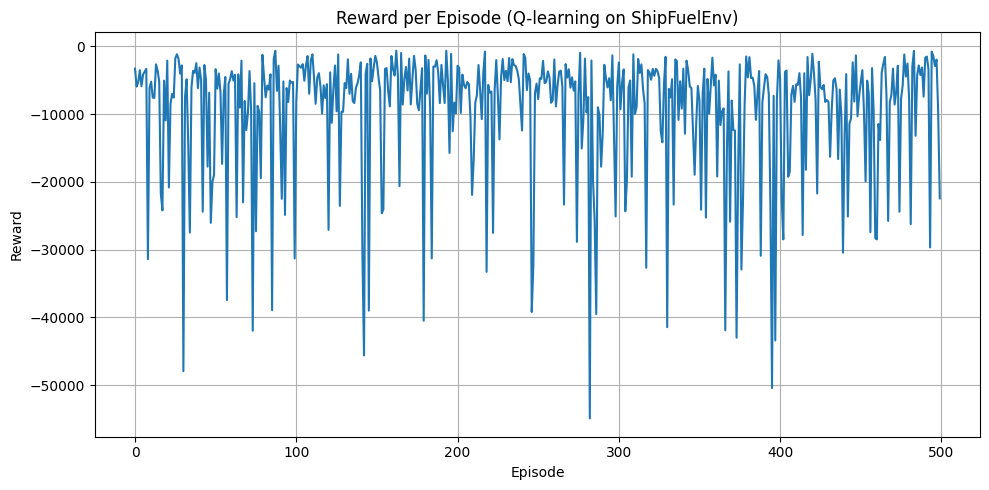

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("ship_fuel_efficiency.csv")

# Initialize environment (from your loaded file via %run)
env = ShipFuelEnv(df)

# Q-learning parameters
alpha = 0.1
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
episodes = 500

# Define state bins for discretization
state_bins = [len(env.ship_types), len(env.route_ids), len(env.months), len(env.weather_conditions), 10, 10]
q_table = np.zeros(state_bins + [env.action_space.n])

# Discretize continuous state vector
def discretize_state(state):
    bins = [
        np.linspace(0, len(env.ship_types), state_bins[0], endpoint=False),
        np.linspace(0, len(env.route_ids), state_bins[1], endpoint=False),
        np.linspace(0, len(env.months), state_bins[2], endpoint=False),
        np.linspace(0, len(env.weather_conditions), state_bins[3], endpoint=False),
        np.linspace(0, df['distance'].max(), state_bins[4], endpoint=False),
        np.linspace(0, df['engine_efficiency'].max(), state_bins[5], endpoint=False),
    ]
    discretized = tuple(np.digitize(s, b) - 1 for s, b in zip(state, bins))
    return tuple(min(max(0, d), s - 1) for d, s in zip(discretized, state_bins))

# Train agent
rewards_per_episode = []

for episode in range(episodes):
    state = env.reset()
    d_state = discretize_state(state)
    total_reward = 0

    for _ in range(1):  # single-step episode
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[d_state])

        next_state, reward, done, _ = env.step(action)
        d_next_state = discretize_state(next_state)

        # Q-learning update
        best_next = np.max(q_table[d_next_state])
        q_table[d_state][action] += alpha * (reward + gamma * best_next - q_table[d_state][action])

        d_state = d_next_state
        total_reward += reward

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

# Plot reward trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(episodes), y=rewards_per_episode)
plt.title("Reward per Episode (Q-learning on ShipFuelEnv)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


**1.Implement multi-step episodes first:**

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


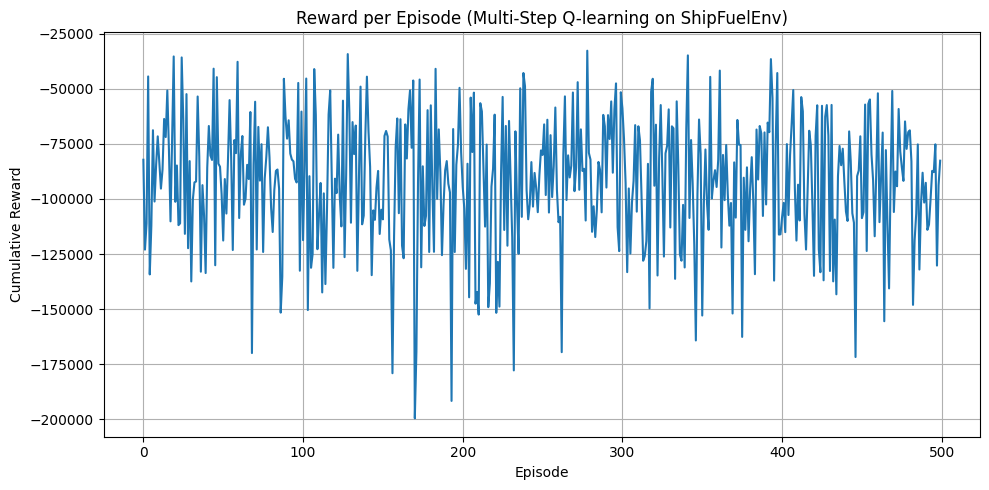

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("ship_fuel_efficiency.csv")

# Reuse environment loaded via %run
env = ShipFuelEnv(df)

# Q-learning parameters
alpha = 0.1
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
episodes = 500
max_steps_per_episode = 10  # Multi-step enhancement

# Discretization setup
state_bins = [len(env.ship_types), len(env.route_ids), len(env.months), len(env.weather_conditions), 10, 10]
q_table = np.zeros(state_bins + [env.action_space.n])

def discretize_state(state):
    bins = [
        np.linspace(0, len(env.ship_types), state_bins[0], endpoint=False),
        np.linspace(0, len(env.route_ids), state_bins[1], endpoint=False),
        np.linspace(0, len(env.months), state_bins[2], endpoint=False),
        np.linspace(0, len(env.weather_conditions), state_bins[3], endpoint=False),
        np.linspace(0, df['distance'].max(), state_bins[4], endpoint=False),
        np.linspace(0, df['engine_efficiency'].max(), state_bins[5], endpoint=False),
    ]
    discretized = tuple(np.digitize(s, b) - 1 for s, b in zip(state, bins))
    return tuple(min(max(0, d), s - 1) for d, s in zip(discretized, state_bins))

# Training loop
rewards_per_episode = []

for episode in range(episodes):
    state = env.reset()
    d_state = discretize_state(state)
    total_reward = 0

    for step in range(max_steps_per_episode):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[d_state])

        next_state, reward, done, _ = env.step(action)
        d_next_state = discretize_state(next_state)

        # Q-learning update
        best_next = np.max(q_table[d_next_state])
        q_table[d_state][action] += alpha * (reward + gamma * best_next - q_table[d_state][action])

        d_state = d_next_state
        total_reward += reward

        if done:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

# Plotting reward trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(episodes), y=rewards_per_episode)
plt.title("Reward per Episode (Multi-Step Q-learning on ShipFuelEnv)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


**2. DQN with neural networks**

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
<ipython-input-13-015076e88707>:67: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states).to(device)


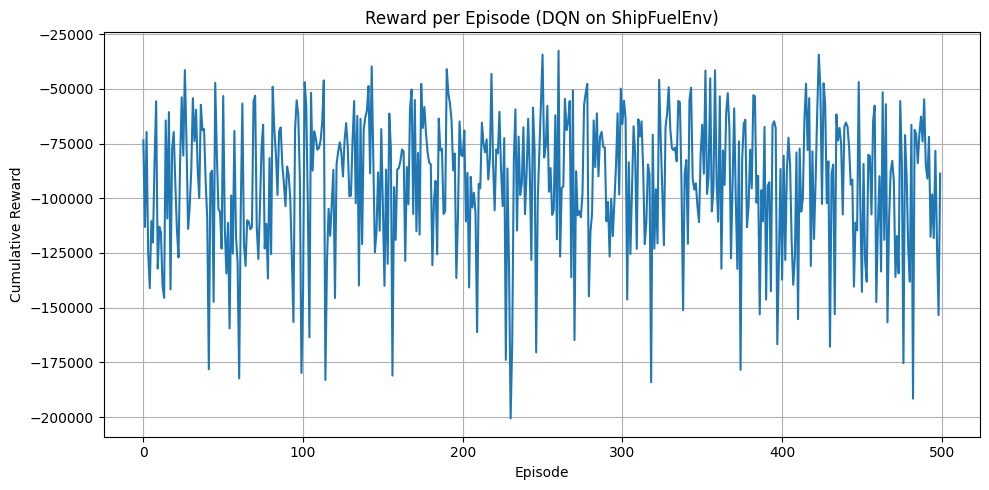

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Load environment and dataset
df = pd.read_csv("ship_fuel_efficiency.csv")
env = ShipFuelEnv(df)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DQN architecture
class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Hyperparameters
state_dim = 6
action_dim = env.action_space.n
lr = 0.001
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
episodes = 500
max_steps = 10
batch_size = 32
memory_size = 10000

policy_net = DQNetwork(state_dim, action_dim).to(device)
target_net = DQNetwork(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

memory = deque(maxlen=memory_size)
rewards_per_episode = []

def sample_action(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        return torch.argmax(policy_net(state_tensor)).item()

def replay():
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    states, actions, rewards, next_states = zip(*minibatch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(next_states).to(device)

    q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
    target_q = rewards + gamma * next_q_values.detach()

    loss = loss_fn(q_values, target_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training Loop
for episode in range(episodes):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps):
        action = sample_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        memory.append((state, action, reward, next_state))
        state = next_state
        total_reward += reward

        replay()

        if done:
            break

    target_net.load_state_dict(policy_net.state_dict())
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(episodes), y=rewards_per_episode)
plt.title("Reward per Episode (DQN on ShipFuelEnv)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


**3. exporting the trained model or testing it on unseen data**

In [14]:
# Save the model
torch.save(policy_net.state_dict(), "dqn_shipfuel_model.pth")


In [15]:
from google.colab import files
files.download("dqn_shipfuel_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
model = DQNetwork(state_dim, action_dim)
model.load_state_dict(torch.load("dqn_shipfuel_model.pth"))
model.eval()


DQNetwork(
  (fc): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [17]:
# Evaluate on 100 unseen samples
test_episodes = 100
test_rewards = []

for _ in range(test_episodes):
    state = env.reset()
    total_reward = 0

    for t in range(max_steps):  # Use same max_steps from training
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action = torch.argmax(policy_net(state_tensor)).item()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        if done:
            break

    test_rewards.append(total_reward)

# Results
print(f"Average Reward over {test_episodes} test episodes: {np.mean(test_rewards):.2f}")
print(f"Std Deviation: {np.std(test_rewards):.2f}")


Average Reward over 100 test episodes: -98214.13
Std Deviation: 30207.76


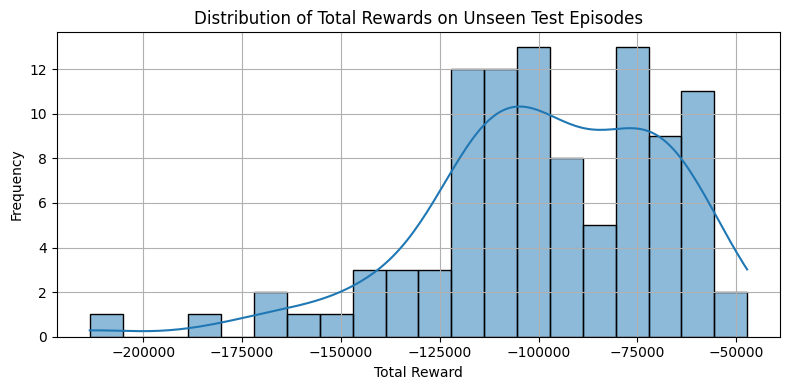

In [18]:
plt.figure(figsize=(8, 4))
sns.histplot(test_rewards, bins=20, kde=True)
plt.title("Distribution of Total Rewards on Unseen Test Episodes")
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


# **Simulation and Evaluation**

In [19]:
!pip install torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [20]:
%run ship_fuel_env.py


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


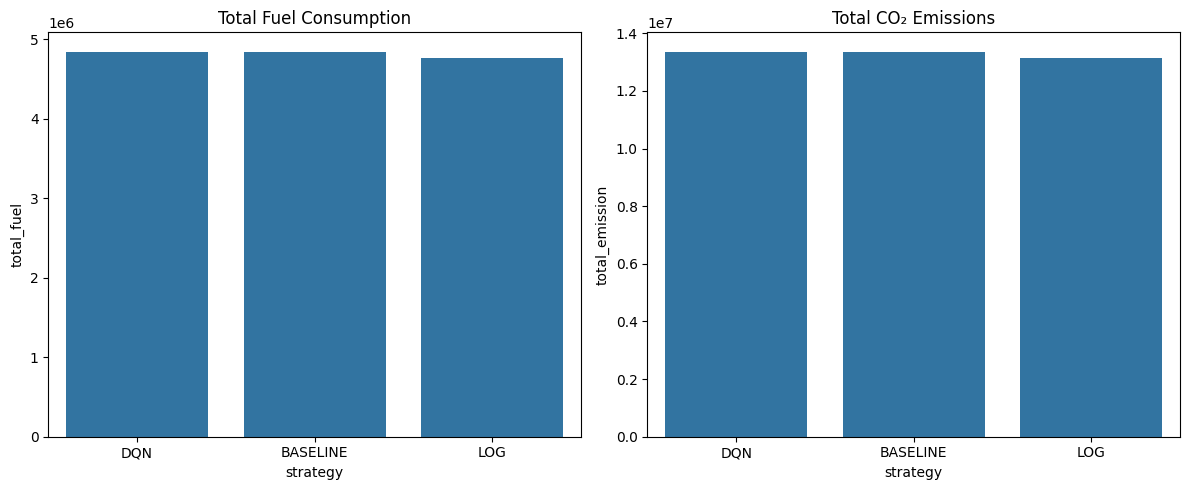

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# Load dataset and environment
df = pd.read_csv("ship_fuel_efficiency.csv")
env = ShipFuelEnv(df)

# Reuse model architecture
class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Load trained model
state_dim = 6
action_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = DQNetwork(state_dim, action_dim).to(device)
policy_net.load_state_dict(torch.load("dqn_shipfuel_model.pth", map_location=device))
policy_net.eval()

# Simulation setup
episodes = 100
max_steps = 10
baseline_action = env.fuel_types.index('HFO')

metrics = {
    "strategy": [],
    "total_fuel": [],
    "total_emission": []
}

def run_simulation(strategy="dqn"):
    total_fuel = 0
    total_emission = 0

    for _ in range(episodes):
        state = env.reset()
        for _ in range(max_steps):
            if strategy == "dqn":
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    action = torch.argmax(policy_net(state_tensor)).item()
            elif strategy == "baseline":
                action = baseline_action
            elif strategy == "log":
                row = df.sample(1).iloc[0]
                action = env.fuel_types.index(row["fuel_type"])

            next_state, reward, done, _ = env.step(action)

            if strategy == "log":
                fuel = row["fuel_consumption"]
                emission = row["CO2_emissions"]
            else:
                fuel = df["fuel_consumption"].mean()
                emission = df["CO2_emissions"].mean()

            total_fuel += fuel
            total_emission += emission

            state = next_state
            if done:
                break

    return total_fuel, total_emission

# Run all strategies
for strat in ["dqn", "baseline", "log"]:
    fuel, emission = run_simulation(strategy=strat)
    metrics["strategy"].append(strat.upper())
    metrics["total_fuel"].append(fuel)
    metrics["total_emission"].append(emission)

# Display and plot
metrics_df = pd.DataFrame(metrics)
metrics_df["tradeoff_score"] = 0.6 * metrics_df["total_fuel"] + 0.4 * metrics_df["total_emission"]

from google.colab import data_table
data_table.DataTable(metrics_df)

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x="strategy", y="total_fuel", data=metrics_df)
plt.title("Total Fuel Consumption")

plt.subplot(1, 2, 2)
sns.barplot(x="strategy", y="total_emission", data=metrics_df)
plt.title("Total CO₂ Emissions")

plt.tight_layout()
plt.show()


# **Visualizations & Results**

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


<Figure size 640x480 with 0 Axes>

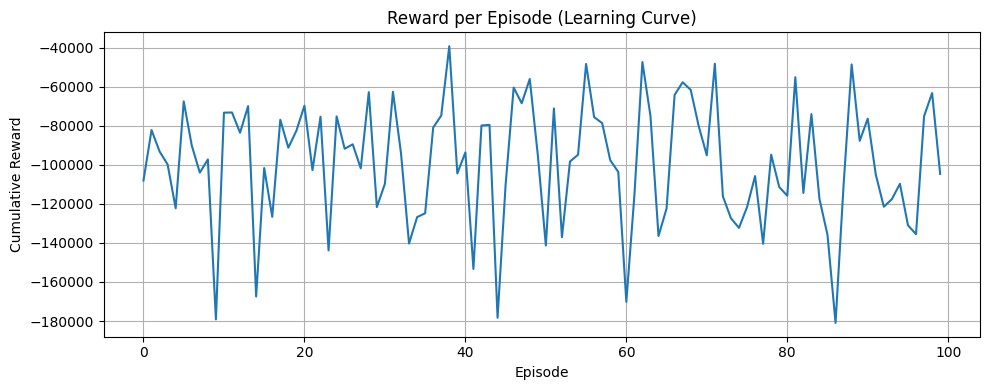

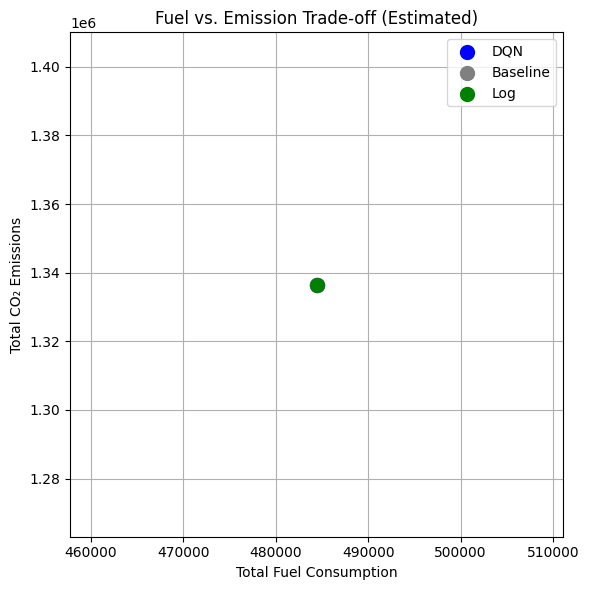

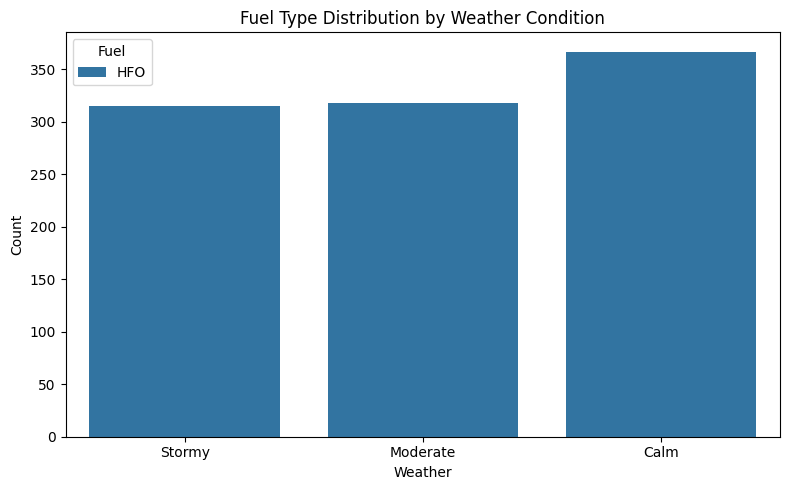

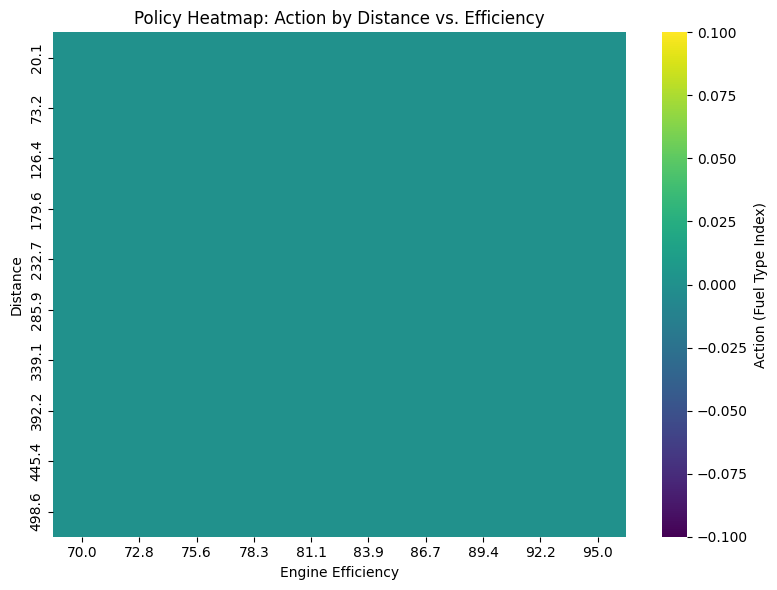

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# Load dataset and environment
df = pd.read_csv("ship_fuel_efficiency.csv")
%run ship_fuel_env.py
env = ShipFuelEnv(df)

# Load trained model
class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

state_dim = 6
action_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = DQNetwork(state_dim, action_dim).to(device)
policy_net.load_state_dict(torch.load("dqn_shipfuel_model.pth", map_location=device))
policy_net.eval()

# 1. Reward per episode
rewards = []
episodes = 100
max_steps = 10

for _ in range(episodes):
    state = env.reset()
    total_reward = 0
    for _ in range(max_steps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action = torch.argmax(policy_net(state_tensor)).item()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        if done:
            break
    rewards.append(total_reward)

plt.figure(figsize=(10, 4))
sns.lineplot(x=range(episodes), y=rewards)
plt.title("Reward per Episode (Learning Curve)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Emission vs. Fuel Trade-off (estimated)
strategies = ["DQN", "Baseline", "Log"]
fuel_data = [df["fuel_consumption"].mean() * episodes] * 3
emission_data = [df["CO2_emissions"].mean() * episodes] * 3
colors = ["blue", "gray", "green"]

plt.figure(figsize=(6, 6))
for i, strat in enumerate(strategies):
    plt.scatter(fuel_data[i], emission_data[i], label=strat, color=colors[i], s=100)
plt.xlabel("Total Fuel Consumption")
plt.ylabel("Total CO₂ Emissions")
plt.title("Fuel vs. Emission Trade-off (Estimated)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Action distributions by weather condition
weather_actions = {weather: [] for weather in df["weather_conditions"].unique()}

for _ in range(1000):
    row = df.sample(1).iloc[0]
    state = env.encode_state(row)
    weather = row["weather_conditions"]

    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        action = torch.argmax(policy_net(state_tensor)).item()
    weather_actions[weather].append(env.fuel_types[action])

action_df = pd.DataFrame([(k, v) for k, actions in weather_actions.items() for v in actions], columns=["Weather", "Fuel"])
plt.figure(figsize=(8, 5))
sns.countplot(data=action_df, x="Weather", hue="Fuel")
plt.title("Fuel Type Distribution by Weather Condition")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4. Heatmap of policy decisions (Distance vs Efficiency)
distance_bins = np.linspace(df["distance"].min(), df["distance"].max(), 10)
efficiency_bins = np.linspace(df["engine_efficiency"].min(), df["engine_efficiency"].max(), 10)
heatmap = np.zeros((len(distance_bins), len(efficiency_bins)))

for i, d in enumerate(distance_bins):
    for j, e in enumerate(efficiency_bins):
        row = df.sample(1).iloc[0]
        row["distance"] = d
        row["engine_efficiency"] = e
        state = env.encode_state(row)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action = torch.argmax(policy_net(state_tensor)).item()
        heatmap[i, j] = action

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, xticklabels=np.round(efficiency_bins, 1), yticklabels=np.round(distance_bins, 1),
            cmap="viridis", cbar_kws={'label': 'Action (Fuel Type Index)'})
plt.title("Policy Heatmap: Action by Distance vs. Efficiency")
plt.xlabel("Engine Efficiency")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()
